In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import os
import zstandard as zstd
import io
import random
import pickle

warnings.filterwarnings("ignore")

In [2]:
conda install zstandard

Channels:
 - defaults
 - conda-forge
Platform: osx-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
def process_csv_files(directory, ticker):
    """
    Convert input csv to dataframes and prepare to process through trading signal.

    Params:
    directory (String): Name of directory that contains list of csv files.

    Returns:
    return (list[DataFrame]): List of pandas DataFrames, one for each trading day.
    """
    
    # Directory containing the CSV files
    
    ret = []
    i = 1
    # Loop through all files in the directory and convert .zst csv to df
    for filename in os.listdir(directory):
        
        if filename.endswith('.zst'):
            filepath = os.path.join(directory, filename)

            try:
                # Open the compressed file in binary mode
                with open(filepath, 'rb') as compressed_file:
                    # Initialize the decompressor
                    dctx = zstd.ZstdDecompressor()
                    
                    # Decompress the file into an in-memory buffer
                    with dctx.stream_reader(compressed_file) as decompressed_stream:
                        text_stream = io.TextIOWrapper(decompressed_stream, encoding='utf-8')
                        print(f"Processing {filename}\n")
                        # Read the decompressed data into a pandas DataFrame
                        df = pd.read_csv(text_stream, parse_dates=['ts_recv', 'ts_event'])
                        print(str(i) + ' read file')
                        df.to_pickle(os.path.join(directory,"day_" + str(i) + ".pkl"))
                        print(str(i) + ' saved file as pickle')
                        i +=1
                        print(f"Processed {filename}\n")
                    
            except Exception as e:
                print(f"Error processing {filename}\n")
                print(e)
                continue
                
            
            
    return 0

In [3]:
def process_csv_files_uncompressed(directory, ticker):
    """
    Convert input csv to dataframes and prepare to process through trading signal.

    Params:
    directory (String): Name of directory that contains list of csv files.

    Returns:
    return (list[DataFrame]): List of pandas DataFrames, one for each trading day.
    """
    
    # Directory containing the CSV files
    
    ret = []
    i = 1
    # Loop through all files in the directory and convert .zst csv to df
    for filename in os.listdir(directory):
        
        if filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)

            try:
                print(f"Processing {filename}\n")
                # Read the decompressed data into a pandas DataFrame
                df = pd.read_csv(filepath, parse_dates=['ts_recv', 'ts_event'])
                print(str(i) + ' read file')
                df.to_pickle(os.path.join(directory,"day_" + str(i) + ".pkl"))
                print(str(i) + ' saved file as pickle')
                i +=1
                print(f"Processed {filename}\n")
                    
            except Exception as e:
                print(f"Error processing {filename}\n")
                print(e)
                continue
                
            
            
    return 0

In [68]:
dfs = process_csv_files('final-dir', 'ANF')

Processing xnas-itch-20240805.mbp-10.csv.zst

1 read file
1 saved file as pickle
Processed xnas-itch-20240805.mbp-10.csv.zst

Processing xnas-itch-20240812.mbp-10.csv.zst

2 read file
2 saved file as pickle
Processed xnas-itch-20240812.mbp-10.csv.zst

Processing xnas-itch-20240823.mbp-10.csv.zst

3 read file
3 saved file as pickle
Processed xnas-itch-20240823.mbp-10.csv.zst

Processing xnas-itch-20240822.mbp-10.csv.zst

4 read file
4 saved file as pickle
Processed xnas-itch-20240822.mbp-10.csv.zst

Processing xnas-itch-20240813.mbp-10.csv.zst

5 read file
5 saved file as pickle
Processed xnas-itch-20240813.mbp-10.csv.zst

Processing xnas-itch-20240830.mbp-10.csv.zst

6 read file
6 saved file as pickle
Processed xnas-itch-20240830.mbp-10.csv.zst

Processing xnas-itch-20240801.mbp-10.csv.zst

7 read file
7 saved file as pickle
Processed xnas-itch-20240801.mbp-10.csv.zst

Processing xnas-itch-20240807.mbp-10.csv.zst

8 read file
8 saved file as pickle
Processed xnas-itch-20240807.mbp-10.c

In [69]:
# Process data
# directory = 'equity-pkl'
# bbo_dfs_nvda = []
# bbo_dfs_anf = []

# tickers = ['NVDA', 'ANF']

# i = 0
# for filename in os.listdir(directory):
#     if filename.endswith('.pkl'):
#         filepath = os.path.join(directory, filename)
#         with open(filepath, 'rb') as file:
#             df = pickle.load(file)
#         for tkr in tickers:
#             print(i)
#             if 'ts_event' in list(df.columns):
#                 # df['ts_event'] = pd.to_datetime(df['ts_event'])
#                 # Set 'ts_event' as index
#                 df = df.set_index('ts_event')
                        
#             bbo_df = df.between_time('13:40', '19:55', inclusive='left')
            
#             tkr_df_nvda = bbo_df[bbo_df['symbol'] == 'NVDA'].resample('100ms').last().ffill()
#             tkr_df_anf = bbo_df[bbo_df['symbol'] == 'ANF'].resample('100ms').last().ffill()

#             #do not concatenate dataframes here - this causes kernel shutdown


#             bbo_dfs_nvda.append(tkr_df_nvda)
#             bbo_dfs_anf.append(tkr_df_anf)

#         i+=1

In [73]:
def moving_average_signal(df, short_window, long_window, b,delay=0):
    """
    Generate trading signals based on moving average cross-over strategy.

    Params:
    prices (Series): asset prices
    short_window (int): Window size for the short-term moving average
    long_window (int): Window size for the long-term moving average
    b (int): Bandwidth parameter that determines the buy/sell thresholds

    Return:
    return (Series): Series with trading signals (+1 for buy, -1 for sell, 0 for hold)
    """
    print(f'Generating MA signal with delay {delay}')
    # Create midprice column (average of bid and ask prices)
    mid_price = (df['bid_px_00'] + df['ask_px_00']) / 2
    
    # Calculate short-term and long-term moving averages
    short_ma = mid_price.rolling(window=short_window).mean()
    long_ma = mid_price.rolling(window=long_window).mean()
    
    # Define thresholds
    upper_threshold = (1 + b) * long_ma
    lower_threshold = (1 - b) * long_ma
    
    signal = pd.Series(0, index=df.index)

    # Generate buy signals (+1 where short_ma > upper_threshold)
    signal[short_ma > upper_threshold] = 1
    
    # Generate sell signals (-1 where short_ma < lower_threshold)
    signal[short_ma < lower_threshold] = -1

    # Delay signal by 'delay' periods to account for trading frictions
    signal = signal.shift(delay).fillna(0)

    #Set signal to 0 at the end of the day to ensure no overnight positions
    signal[df.index.time > pd.to_datetime('19:55').time()] = 0

    return signal

def momentum_in_price_signal(df, short_window, long_window, b,delay=0):
    """
    Generate trading signals based on momentum in price strategy.

    Params:
    prices (Series): asset prices
    short_window (int): Window size for the short-term moving average
    long_window (int): Window size for the long-term moving average
    b (int): Bandwidth parameter that determines the buy/sell thresholds

    Return:
    return (Series): Series with trading signals (+1 for buy, -1 for sell, 0 for hold)
    """
    print(f'Generating momentum in price signal with delay {delay}')
    # Create midprice column (average of bid and ask prices)
    mid_price = (df['bid_px_00'] + df['ask_px_00']) / 2
    returns = mid_price.pct_change()

    # Calculate short-term and long-term moving averages
    short_ma = returns.rolling(window=short_window).mean()
    long_ma = returns.rolling(window=long_window).mean()
    
    # Define thresholds
    upper_threshold = (1 + b) * long_ma
    lower_threshold = (1 - b) * long_ma
    
    signal = pd.Series(0, index=df.index)

    # Generate buy signals (+1 where short_ma > upper_threshold)
    signal[short_ma > upper_threshold] = 1
    
    # Generate sell signals (-1 where short_ma < lower_threshold)
    signal[short_ma < lower_threshold] = -1

    # Delay signal by 'delay' periods to account for trading frictions
    signal = signal.shift(delay).fillna(0)

    #Set signal to 0 at the end of the day to ensure no overnight positions
    signal[df.index.time > pd.to_datetime('19:55').time()] = 0

    return signal

def spread_order_imbalance(df, short_window,long_window, delay=0):
    """
    Generate trading signals based on spread order imbalance strategy.

    Params:
    df (DataFrame): DataFrame containing bid and ask prices and volumes
    delay (int): Number of periods to delay the signal

    Return:
    return (Series): Series with trading signals (+1 for buy, -1 for sell, 0 for hold)
    """
    print(f'Generating spread order imbalance signal with delay {delay}')
    # Calculate spread
    spread = df['ask_px_00'] - df['bid_px_00']

    # Calculate short-term and long-term moving averages of spread
    spread_ma_short= spread.rolling(window=short_window).mean()
    spread_ma_long = spread.rolling(window=long_window).mean()

    
    # Calculate order imbalance
    order_imbalance = (df['ask_sz_00'] - df['bid_sz_00']) / (df['ask_sz_00'] + df['bid_sz_00'])
    
    # Generate signal based on order imbalance and spread
    signal = pd.Series(0, index=df.index)
    signal[(spread_ma_short<spread_ma_long)&(order_imbalance > 0.5)] = 1
    signal[(spread_ma_short>spread_ma_long)&(order_imbalance < -0.5)] = -1

    # Delay signal by 'delay' periods to account for trading frictions
    signal = signal.shift(delay).fillna(0)

    #Set signal to 0 at the end of the day to ensure no overnight positions
    signal[df.index.time > pd.to_datetime('19:55').time()] = 0

    return signal





In [74]:
#This cell is not used anywhere
def update_order_book(bids, asks, bid_price, bid_size, ask_price, ask_size):
    """
    Update the 5-level deep order book with new bid and ask data.
    Params:
     bids (DataFrame): DataFrame maintaining top 3 bid prices and sizes.
     asks (DataFrame): DataFrame maintaining top 3 ask prices and sizes.
     bid_price (float): New bid price.
     bid_size (int): New bid size.
     ask_price (float): New ask price.
     ask_size (int): New ask size.

    Returns:
    - Updated bids and asks DataFrames.
    """

    # Update bids
    if bid_price > 0 and bid_size > 0:
        if (bids['price'] == bid_price).any():
            # If bid price already exists, update the size
            bids.loc[bids['price'] == bid_price, 'size'] = bid_size
        else:
            # If it's a new bid price, add it and sort
            new_bid = pd.DataFrame({'price': [bid_price], 'size': [bid_size]})
            bids = pd.concat([bids, new_bid]).nlargest(3, 'price').reset_index(drop=True)

    # Update asks
    if ask_price > 0 and ask_size > 0:
        if (asks['price'] == ask_price).any():
            # If ask price already exists, update the size
            asks.loc[asks['price'] == ask_price, 'size'] = ask_size
        else:
            # If it's a new ask price, add it and sort
            new_ask = pd.DataFrame({'price': [ask_price], 'size': [ask_size]})
            asks = pd.concat([asks, new_ask]).nsmallest(3, 'price').reset_index(drop=True)

    return bids, asks

def process_mpb10_data(mpb10_df):
    """
    Process MPB-10 data to maintain a 3-level deep order book for each timestamp.

    Params:
    - mpb10_df (DataFrame): DataFrame containing the MPB-10 data with ts_event as index.

    Returns:
    - bids (DataFrame): DataFrame of top 3 bid prices and sizes indexed by ts_event.
    - asks (DataFrame): DataFrame of top 3 ask prices and sizes indexed by ts_event.
    """

    # Initialize empty DataFrames for the top 3 levels of bids and asks
    bids = pd.DataFrame(columns=['ts_event', 'bid_px_00', 'bid_sz_00', 'bid_px_01', 'bid_sz_01', 'bid_px_02', 'bid_sz_02'])
    asks = pd.DataFrame(columns=['ts_event', 'ask_px_00', 'ask_sz_00', 'ask_px_01', 'ask_sz_01', 'ask_px_02', 'ask_sz_02'])

    for index, row in mpb10_df.iterrows():
        # Extract bid and ask prices and sizes from each row
        bid_data = {
            'ts_event': index,
            'bid_px_00': row['bid_px_00'], 'bid_sz_00': row['bid_sz_00'],
            'bid_px_01': row['bid_px_01'], 'bid_sz_01': row['bid_sz_01'],
            'bid_px_02': row['bid_px_02'], 'bid_sz_02': row['bid_sz_02']
        }

        ask_data = {
            'ts_event': index,
            'ask_px_00': row['ask_px_00'], 'ask_sz_00': row['ask_sz_00'],
            'ask_px_01': row['ask_px_01'], 'ask_sz_01': row['ask_sz_01'],
            'ask_px_02': row['ask_px_02'], 'ask_sz_02': row['ask_sz_02']
        }

        # Use concat instead of append to add rows to bids and asks DataFrames
        bids = pd.concat([bids, pd.DataFrame([bid_data])], ignore_index=True)
        asks = pd.concat([asks, pd.DataFrame([ask_data])], ignore_index=True)

    # Set 'ts_event' as the index for both bids and asks
    bids.set_index('ts_event', inplace=True)
    asks.set_index('ts_event', inplace=True)

    return bids, asks


In [91]:
def execute_trading_signal(df, signal, order_size=1_000_000):
    """
    Execute the trading signal based on the available order book depth and calculate actual P&L.
    
    Params:
    bbo_df (DataFrame): DataFrame containing the order book and signals for each day.
    signal (Series): Series containing the generated trading signals.
    order_size (float): Size of the order for each trade (default $1M).
    
    Returns:
    DataFrame: Updated DataFrame with calculated returns.
    """

    # Initialize position and return
    position = 0
    shares_held = 0
    bbo_df = df.copy()
    bbo_df['return'] = 0

    # Process MPB-10 data to get 3-level deep order book
    #bids, asks = process_mpb10_data(bbo_df)
    bids = bbo_df[['bid_px_00', 'bid_sz_00', 'bid_px_01', 'bid_sz_01', 'bid_px_02', 'bid_sz_02']].copy()
    asks = bbo_df[['ask_px_00', 'ask_sz_00', 'ask_px_01', 'ask_sz_01', 'ask_px_02', 'ask_sz_02']].copy()

    # Track the first signal to open a position, then exit when the signal reverses
    open_position = False
    
    for i in signal.index:
        current_signal = signal.loc[i]
        
        # Buy logic: first time signal turns +1 and we don't have an open position
        if current_signal == 1 and (not open_position or shares_held < 0):
            shares_bought = 0
            investment = 0

            # Buy up to 3 levels of the ask side until $1M is spent
            for level in range(3):
                ask_price = asks.loc[i, f'ask_px_0{level}']
                ask_size = asks.loc[i, f'ask_sz_0{level}']
                level_investment = min(order_size - shares_held*ask_price - investment, ask_price * ask_size)

                # Calculate number of shares to buy
                level_shares = level_investment / ask_price
                shares_bought += level_shares
                investment += level_investment
                
                if investment >= order_size:
                    break  # Exit loop when $1M investment is reached
            
            position += investment
            shares_held += shares_bought
            open_position = True  # Mark that position is open
            
            # Mark the negative cash flow from buying
            bbo_df.loc[i, 'return'] = -investment
            
        # Sell logic: first time signal turns -1 and we don't have an open position
        elif current_signal == -1 and (not open_position or shares_held > 0):
            shares_sold = 0
            revenue = 0

            # Sell up to 3 levels of the bid side, until $1M worth of shares are sold
            for level in range(3):
                bid_price = bids.loc[i, f'bid_px_0{level}']
                bid_size = bids.loc[i, f'bid_sz_0{level}']
                level_revenue = min(order_size + bid_price*shares_held - revenue, bid_price * bid_size)
                level_shares = level_revenue / bid_price

                shares_sold += level_shares
                revenue += level_revenue
                
                if revenue >= order_size:
                    break
            
            position -= revenue
            shares_held -= shares_sold
            open_position = True

            # Mark the positive cash flow from selling
            bbo_df.loc[i, 'return'] = revenue

        
        # Exit logic: signal turns 0 and we have an open position
        elif current_signal == 0 and open_position:
            # Liquidate the position by settling the open trade
            if shares_held > 0:
                # Sell all shares at the bid price
                ask_price = asks.loc[i, 'ask_px_00']
                ask_size = asks.loc[i, 'ask_sz_00']
                sell_qty = min(shares_held, ask_size)
                revenue = sell_qty * ask_price
                position -= revenue
                shares_held -= sell_qty

                if(shares_held == 0):
                    open_position = False

                # Mark the positive cash flow from selling
                bbo_df.loc[i, 'return'] = revenue

            elif shares_held < 0:
                # Buy back all shares at the ask price
                bid_price = bids.loc[i, 'bid_px_00']
                bid_size = bids.loc[i, 'bid_sz_00']
                buy_qty = min(-shares_held, bid_size)
                investment = buy_qty * bid_price
                position += investment
                shares_held += buy_qty
                if(shares_held == 0):
                    open_position = False

                # Mark the negative cash flow from buying
                bbo_df.loc[i, 'return'] = -investment

    # Scale the cumulative return
    bbo_df['cumulative_return'] = (bbo_df['return']).cumsum()
    bbo_df['scaled_return'] = bbo_df['cumulative_return'] / 1_000_000
    
    return bbo_df


In [113]:
# Process data
directory = 'final-dir'

tickers = ['ANF']
signal_list=[moving_average_signal, momentum_in_price_signal, spread_order_imbalance]
params=[(50,200,0.005),(10,30,0.005),(50,70)]
def signal_and_trade(ticker, directory):
    
    daily_returns = {'00':[], '01':[], '02':[],'10':[], '11':[],'12':[], '20':[], '21':[], '22':[]}
    for i in tqdm(range(1,23)):
        filename = 'day_' + str(i) + '.pkl'
        filepath = os.path.join(directory, filename)
        
        with open(filepath, 'rb') as file:
            df = pickle.load(file)
            
        #print('Successfully loaded pkl file. Processing as dataframe.')
        
        if 'ts_event' in list(df.columns):
            df = df.set_index('ts_event')
                    
        bbo_df = df.between_time('13:40', '19:55', inclusive='left')
        tkr_df= bbo_df[bbo_df['symbol'] == ticker].resample('100ms').last().ffill()

        #print('Successfully cleaned DataFrame for processing. Sending to generate returns.')
        
        for delay in range(3):
            delay_param=delay if delay!=2 else 10
            for i in range(3):
                if(i==0 or i==1):
                    signal = signal_list[i](tkr_df, params[i][0], params[i][1], params[i][2], delay=delay_param)
                else:
                    signal = signal_list[i](tkr_df, params[i][0], params[i][1], delay=delay_param)
                returns = execute_trading_signal(tkr_df, signal)
                daily_returns[str(i)+str(delay)].append(returns["cumulative_return"].tail(1).values[0])
                

        #print('Returns sucessfully generated for ' + filename, '\n')
        
        i+=1
        
    return daily_returns
                

In [114]:
df = signal_and_trade('ANF', directory)

  0%|          | 0/22 [00:00<?, ?it/s]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


  5%|▍         | 1/22 [00:31<11:02, 31.55s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


  9%|▉         | 2/22 [01:05<11:01, 33.06s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 14%|█▎        | 3/22 [01:38<10:23, 32.80s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 18%|█▊        | 4/22 [02:07<09:28, 31.58s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 23%|██▎       | 5/22 [02:37<08:41, 30.70s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 27%|██▋       | 6/22 [03:06<08:06, 30.40s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 32%|███▏      | 7/22 [03:37<07:38, 30.54s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 36%|███▋      | 8/22 [04:05<06:54, 29.58s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 41%|████      | 9/22 [04:34<06:23, 29.47s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 45%|████▌     | 10/22 [05:02<05:49, 29.09s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 50%|█████     | 11/22 [05:31<05:17, 28.89s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 55%|█████▍    | 12/22 [06:00<04:51, 29.15s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 59%|█████▉    | 13/22 [06:29<04:22, 29.14s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 64%|██████▎   | 14/22 [06:54<03:41, 27.75s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 68%|██████▊   | 15/22 [09:31<07:46, 66.63s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 73%|███████▎  | 16/22 [10:01<05:34, 55.68s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 77%|███████▋  | 17/22 [10:31<03:59, 47.87s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 82%|████████▏ | 18/22 [11:01<02:50, 42.64s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 86%|████████▋ | 19/22 [11:31<01:56, 38.92s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 91%|█████████ | 20/22 [11:59<01:10, 35.41s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


 95%|█████████▌| 21/22 [12:37<00:36, 36.41s/it]

Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


100%|██████████| 22/22 [13:12<00:00, 36.04s/it]


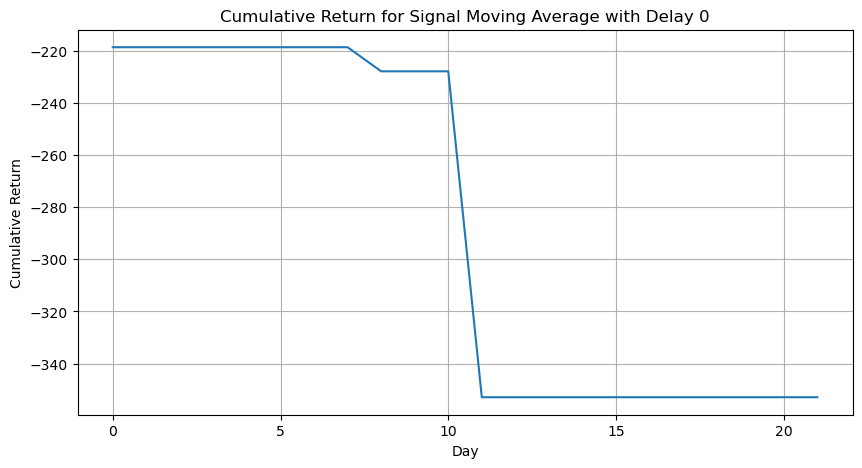

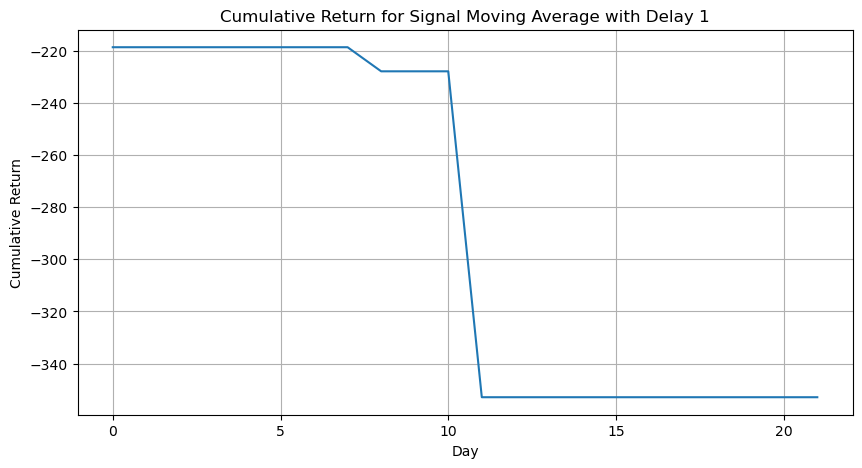

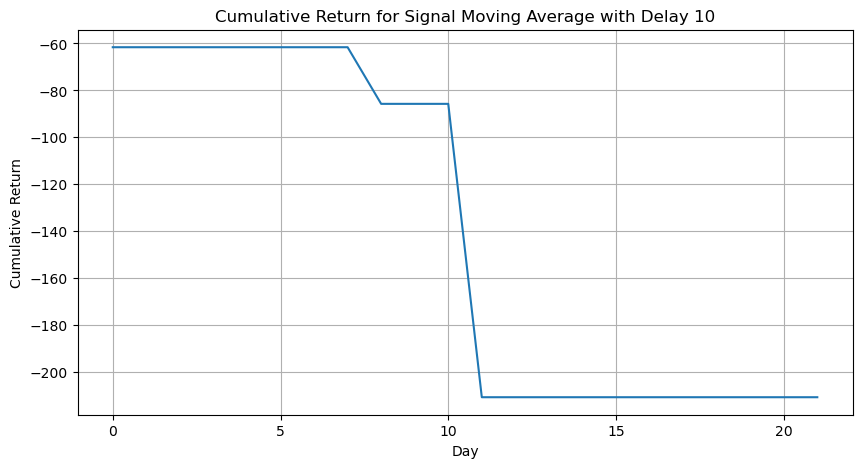

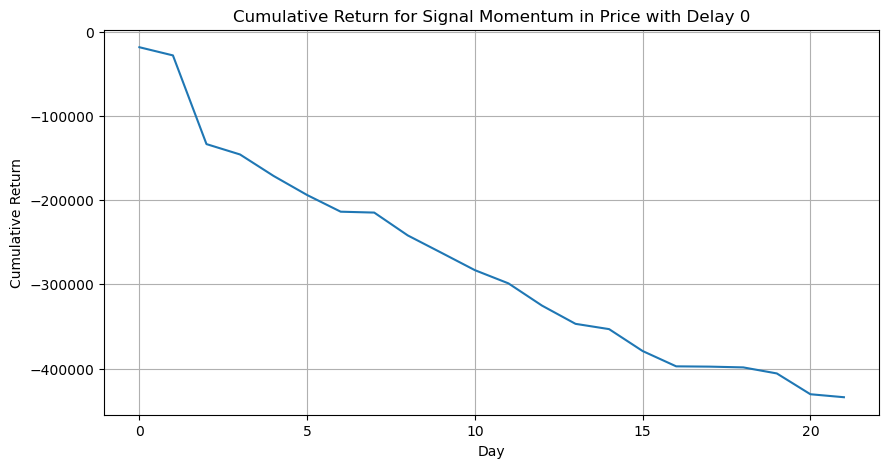

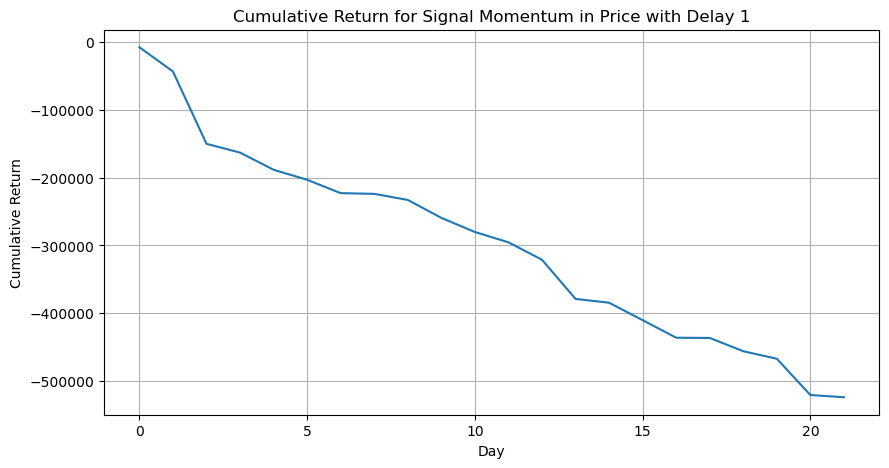

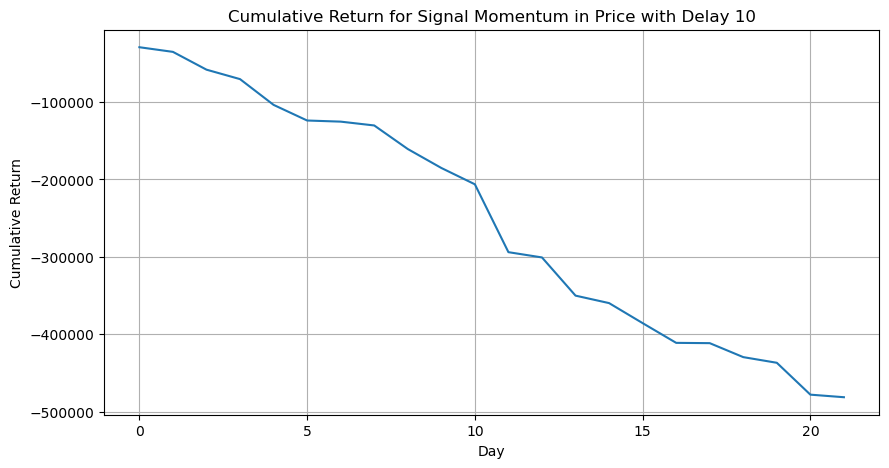

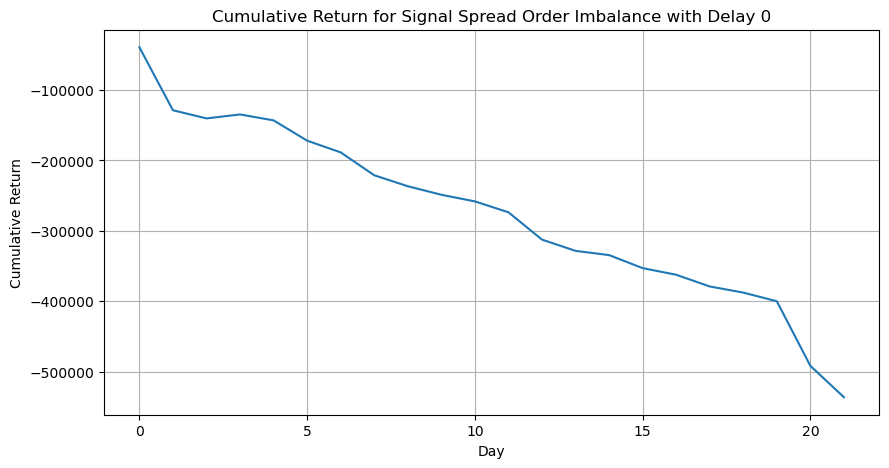

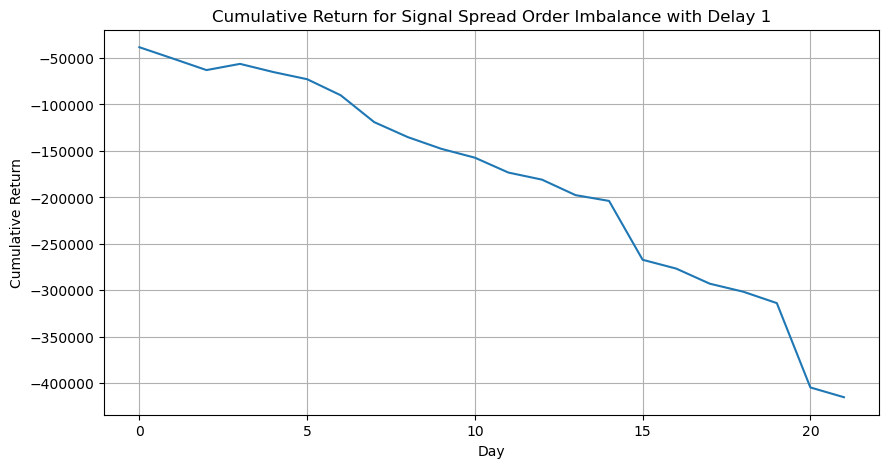

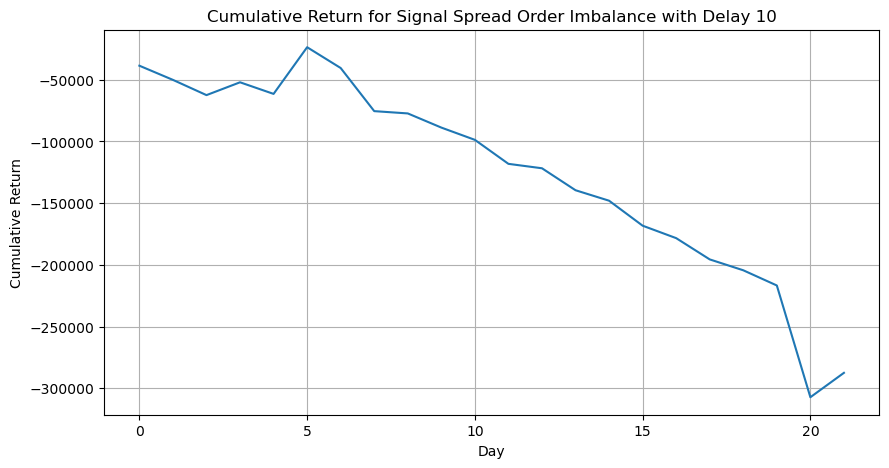

In [115]:
import matplotlib.pyplot as plt

# Iterate through the dictionary df
for key, value in df.items():
    # Convert the list into a pandas Series
    series = pd.Series(value).cumsum()
    delay_param = key[1] if key[1] != '2' else 10
    # Plot the Series
    plt.figure(figsize=(10, 5))
    plt.plot(series)
    delay = int(key[1])
    if key[0] == '0':
        signal = 'Moving Average'
    elif key[0] == '1':
        signal = 'Momentum in Price'
    else:
        signal = 'Spread Order Imbalance'
    plt.title(f'Cumulative Return for Signal {signal} with Delay {delay_param}')
    plt.xlabel('Day')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.show()

In [67]:
# for testing purposes to speed up debugging
i = 0
directory='test-dir'
for filename in os.listdir(directory):
    if filename.endswith('.pkl'):
        print('Processing ' + filename)
        
        filepath = os.path.join(directory, filename)
        
        with open(filepath, 'rb') as file:
            df = pickle.load(file)
            
        print('Successfully loaded pkl file. Processing as dataframe.')
        
        if 'ts_event' in list(df.columns):
            df = df.set_index('ts_event')
                    
        bbo_df = df.between_time('13:40', '19:55', inclusive='left')
        tkr_df = bbo_df[bbo_df['symbol'] == 'ANF'].resample('5s').last().ffill()

        #df = tkr_df.head(500) # to speed up testing

        signal_ma = moving_average_signal(tkr_df, 2,5, 0.0005,delay=0)
        signal_mp = momentum_in_price_signal(tkr_df, 2,5, 0.0005,delay=0)
        signal_combined = spread_order_imbalance(tkr_df,7,10,delay=0)

        print('Successfully generated trading signal. Sending to generate returns.')
        
        returns_0 = execute_trading_signal(tkr_df, signal_ma)
        returns_1 = execute_trading_signal(tkr_df, signal_mp)
        returns_2 = execute_trading_signal(tkr_df, signal_combined)
        
        print('Returns sucessfully generated for ' + filename, '\n')

        print(f'Moving average return:{returns_0["cumulative_return"].tail(1).values[0]}')
        print(f'Momentum return:{returns_1["cumulative_return"].tail(1).values[0]}')
        print(f'Combined return:{returns_2["cumulative_return"].tail(1).values[0]}')
        # random_sample = np.sort(random.sample(range(0, len(returns_0)), 100))
        # returns_0['cumulative_return'].plot()
        # returns_1['cumulative_return'].plot()
        # returns_2['cumulative_return'].plot()

        i+=1

        if i > 3:
            break


Processing day_1.pkl
Successfully loaded pkl file. Processing as dataframe.
Successfully generated trading signal. Sending to generate returns.
Returns sucessfully generated for day_1.pkl 

Moving average return:958.280000000059
Momentum return:-5241.880000000005
Combined return:-6950.149999999961


In [ ]:
# signal = moving_average_signal(test, short_window=50, long_window=500, b=0.0001)

# returns = execute_trading_signal(test, signal)

In [ ]:
# theoretical, hopefully this works

returns = []
for df in bbo_dfs_anf:
    ret = execute_trading_signal(df, signal)
    returns.append(ret)